# Replicate Error

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
import scipy.stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from collections import OrderedDict

%matplotlib inline

## Aggregate Error Data

In [2]:
man = quail.load_egg('../data/man_egg.egg')
auto = quail.load_egg('../data/auto_egg.egg')

### External mistake HERE (see comment)

Explanation for reviewers: counted internal errors

In [3]:
man_errs = {'external': [], 'intrusion': [], 'num recalled': [], 'sep_rec': []}
auto_errs = {'external': [], 'intrusion': [], 'num recalled': [], 'sep_rec': []}

for trans,dic in zip([man,auto], [man_errs, auto_errs]): 
    for sub in range(len(auto.meta['ids'])):
    
        all_presented = []
        external = []
        intrusion = [0]*8
        num_recalled = []
        
        for lst in range(0,8):
            ext_count = 0
            
            # load pres and rec
            recalled = [x for x in trans.rec.loc[sub].loc[lst].values if type(x)==str] 
            presented = trans.pres.loc[sub].loc[lst].values
            num_recalled.append(len(recalled))
            
            # select recalls not from this pres 
            extras = [x for x in recalled if x not in presented]
            
            # if extra word prev presented, add to intrusion 
            for word in extras:
                intr = 0
                
                for idx,sublist in enumerate(all_presented):
                    if word in sublist:
                        intrusion[lst-idx]+=1.0
                        intr += 1
                #if intr == 0:
                
                
############### MISTAKE HERE################
                # ADD EVERY WORD IN EXTRAS TO EXTERNAL ERROR COUNTER
                ext_count+=1
############### MISTAKE HERE################             
                
       
            # append prop recalls that are external errors
            external.append(ext_count/float(len(recalled)))
            all_presented.append(presented)
            
        
        dic['external'].append(np.mean(external))
        dic['intrusion'].append(intrusion)  
        dic['num recalled'].append(sum(num_recalled))
        dic['sep_rec'].append(num_recalled)

## Plot External Errors

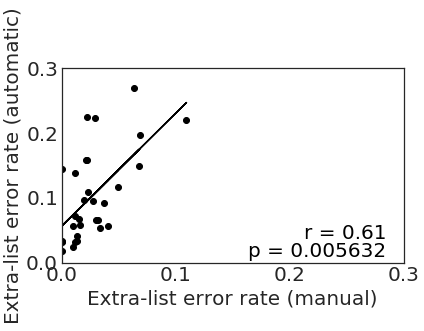

In [4]:
#plot average proportion of external errors in man vs. auto transcription on scatter plot
sns.set_style('white')
fig, ax = plt.subplots()
plt.scatter(man_errs['external'], auto_errs['external'], color = 'black', edgecolors = 'black')

#label axes
ax.set_xlabel('Extra-list error rate (manual)', size = 20)
ax.set_ylabel('Extra-list error rate (automatic)', size = 20)
plt.tick_params(labelsize=20)
plt.xlim(0, .3)
plt.ylim(0, .3)

#get line of best fit
reg_line = np.polyfit(man_errs['external'], auto_errs['external'], 1)
reg_line_fn = np.poly1d(reg_line)
plt.plot(man_errs['external'], reg_line_fn(man_errs['external']), color = 'black')

#get R value
r = pearsonr(man_errs['external'], auto_errs['external'])
r_plot = str(r[0])
p_plot=str(r[1])
#print r
ax.text(.95, .2, 'r = '+r_plot[0:4], horizontalalignment='right', verticalalignment='top',
transform=ax.transAxes, color='black', fontsize=20)
ax.text(0.95, 0.03, 'p = '+p_plot[0:4]+p_plot[-4:], horizontalalignment='right',
transform=ax.transAxes, color='black', fontsize=20)

#save plot and show
plt.tight_layout()
plt.style.use('default')
fig.savefig('XLI_KZ.pdf')
plt.show()

# Prep n-back (divide, normalize)

Explanation for reviewers:

*SUBMITTED* : a division of total n-back over length of a single recalled list

*UPDATED / DESIRED* : division of total n-back over length summed recalled lists

### Error HERE (worse than I realized)

In [5]:
mans = []
autos = []

# for man and auto
for typ in [man_errs,auto_errs]:
    
    # loop over zip( that subject's total n-back errors , # of recalled words (list-wise) )
    for x,y in zip(typ['intrusion'],typ['sep_rec']):
        
########MISTAKE HERE #########################
        # DIVIDE SUB'S *TOTAL* N-BACK ERRORS BY # RECALLS ON *Nth LIST*       
##############################################
        
        if typ == man_errs:
            mans.append([a/b for a,b in zip(x,y)])
            
        else:
            autos.append([a/b for a,b in zip(x,y)])

In [6]:
# for man and auto
for typ in [mans,autos]:
    
    # for each list
    for index,lst in enumerate(typ):
        
        # for each value
        for idx,x in enumerate(lst):
            
            # if not 0th index (recall list 1):
            if idx!=0:
                
                # NORMALIZATION
                # divide each value by 16*index
                typ[index][idx] = x/(idx*16)

# plot

(0.9455632436872277, 3.5173899792318626e-15)
(0.8489489313912536, 3.053752485009386e-09)
(0.9916909099372455, 1.7406855493006056e-26)
(nan, 1.0)
(0.7376288499246813, 3.30706068770866e-06)


/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


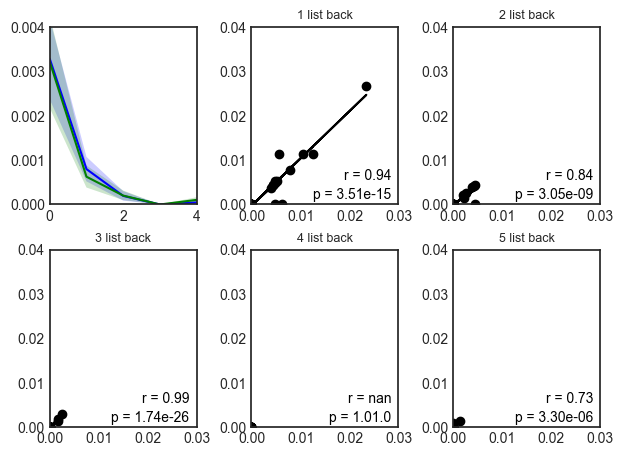

In [7]:
sns.set_style('white')

#set up the grid
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(pad=2, w_pad=1.5, h_pad=1.5)


#plot prior list errors for each list back
man_means = []
auto_means = []

man_full = []
auto_full = []

for i in range(1, 6):
    
    ax = axs.flat[i]
    
    man_plot = [x[i] for x in mans]
    auto_plot = [x[i] for x in autos]
    
    man_full.append(man_plot)
    auto_full.append(auto_plot)

    ax.scatter (man_plot, auto_plot, color = 'black', edgecolors = 'black')  
    
    #get R value
    r = pearsonr(man_plot, auto_plot)
    r_plot = str(r[0])
    p_plot = str(r[1])
    print(r)
    
    #get line of best fit
    reg_line = np.polyfit(man_plot, auto_plot, 1)
    reg_line_fn = np.poly1d(reg_line)
    ax.set_title(str(i)+' list back', size = 9)
    ax.set_xlim(0, 0.03)
    ax.set_ylim(0, 0.04)
    ax.plot(man_plot, reg_line_fn(man_plot), color = 'black')
    
    ax.text(0.95, 0.03, 'p = '+p_plot[0:4]+p_plot[-4:], horizontalalignment='right',
    transform=ax.transAxes, color='black', fontsize=10)
    ax.text(.95, .2, 'r = '+r_plot[0:4], horizontalalignment='right', verticalalignment='top',
    transform=ax.transAxes, color='black', fontsize=10)
    
    man_means.append(np.mean(man_plot))
    auto_means.append(np.mean(auto_plot))
    
#     print('correlation for '+str(i)+' lists back: ')
    

x = np.array(man_full)
y = np.array(auto_full)
sns.tsplot(np.transpose(x), ax=axs.flat[0], color = 'blue')
sns.tsplot(np.transpose(y), ax=axs.flat[0], color = 'green')
axs.flat[0].set_ylim(0,.004)

#legend
ax.legend(loc = 'upper right', fontsize = 'x-small')
fig.savefig('updated.pdf')
